# Classification de documents : prise en main des outils

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats


## Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

# Etape 1: charger les données

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import FrenchStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer , TfidfTransformer
from collections import Counter 
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split , KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split , KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model as lin

import matplotlib.pyplot as plt

import pandas as pd

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss 

import time

import process as pr
%load_ext autoreload
%autoreload 2

import codecs
import re
import os.path

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs


In [6]:
fname = "./AFDpresidentutf8/corpus.tache1.learn.utf8"

alltxts,alllabs = load_pres(fname)



In [5]:
#print(alltxts[:10],len(alllabs))
#print(alltxts[4])
#print(alllabs[4])
#print(alltxts[-1])
#print(alllabs[-1])



In [2]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


In [3]:
path = "./AFDmovies/movies1000/"

alltxts,alllabs = load_movies(path)

In [56]:
#print(len(alltxts),len(alllabs))
#print(alltxts[0])
#print(alllabs[0])
#print(alltxts[-1])
#print(alllabs[-1])
#print(alllabs[:1000])
#print(alllabs[:-1000])

# Transformation paramétrique du texte

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

### Data Pre-processing

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
class tranform():
    
    def __init__(self,text):
        self.text = text

    def text_trans(self,num=1):
        
        def token_regex(data):
            tokenizer = nltk.RegexpTokenizer(r"[a-zA-Z]{3,}")
            return [tokenizer.tokenize(doc) for doc in data]

        def stop_word(tokens):
            stop_words = stopwords.words("english")
            return [[w for w in sentence if not w.lower() in stop_words] for sentence in tokens ]

        def stem(tokens):
            ps = FrenchStemmer()
            return [ [ps.stem(word) for word in sentence] for sentence in tokens]
        
        dico  = { 1 : [token_regex,stop_word,stem],
                  2 : [token_regex],
                  3 : [token_regex,stop_word],
                  4 : [token_regex,stem]
                }

        for t in dico[num]:
            self.text = t(self.text)
    
        
        self.text = [" ".join(doc)  for doc in self.text]
        
        return self.text
    #max_features = maxfeat ,ngram_range= ngram , vocabulary  = vocab, max_df = maxdf, min_df = mindf
    #,maxfeat =None , ngram = (1,1) , maxdf = 1, mindf = 0 ,vocab = None
    def vect(self,trans_text):
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(trans_text)
        #self.vocabulary = vectorizer.get_feature_names()
        self.len = len(self.vocabulary)
    
        return X
    #, ngram=(1,1),maxdf = 1, mindf = 1 , vocab = None
    # , ngram, maxdf, mindf ,vocab
    def vect_tfidf(self,trans_text,maxdf = 1.):
        vectorizer = TfidfVectorizer(max_df = maxdf)
        X = vectorizer.fit_transform(trans_text)
        self.vocabulary = vectorizer.get_feature_names()
        
        return X
    
    def tfidf_most_less_words(self,X):
        sum_words = X.sum(axis = 0) 
        vec = CountVectorizer().fit(self.text)
        
        #max_features=1500
        words_freq  = { word : sum_words[0, idx] for word, idx in  vec.vocabulary_.items()}
        words_freq1 = sorted(words_freq.items(), key=lambda x:x[1], reverse=True)
        most_frequent = words_freq1[:100] # les 100 mots les plus fréquents
        less_frequent = words_freq1[-200:] # les 100 mots les moins fréquents 
        
        #voc1 on eneleve les mots tres fréquents et moins fréquents 
        voc1 = pr.generate_vocabulary (self.text, 2500, most_frequent + less_frequent)

        v1  = TfidfVectorizer(vocabulary = voc1)
        mat = v1.fit_transform(self.text)
        
        return mat
        


## Variation hyper parametres

In [64]:
scores = dict()
grid_mean_scores = dict()
estimators = []
time_model = []
for mod in models.keys():
        
    if mod == 'svm':
            
        param_grid = {
            "C" : [0.9, 0.1, 0.5, 1, 5],
            "kernel": ['linear']
        }
            
    elif mod == 'logistic':
        
        param_grid = {
            "C" : [0.1,0.5,0.9,1,5]
        }
        
    time_var = []
    best_scores = []
    for i in np.arange(0.5,1,0.05):
        tran = tranform(alltxts)
        corpus = tran.text_trans(1)
        X = tran.vect_tfidf(corpus, maxdf = i)
        X_tr, X_test, y_tr, y_test = train_test_split(X,alllabs,test_size = 0.3, random_state = 0)

        start = time.time()
        
        if mod != 'mnb':
            
            grid = GridSearchCV(models[mod], param_grid, cv=5, scoring='accuracy')
            grid.fit(X_tr, y_tr)
            print(pd.DataFrame(grid.cv_results_)[['mean_test_score', 'params']])
            grid_mean_scores[mod] = grid.cv_results_['mean_test_score']
            estimators.append(grid)
            best_scores.append(grid.best_score_)
            
        else :
            
            models[mod].fit(X_tr,y_tr)
            best_scores.append(models[mod].score(X_test,y_test))

        end = time.time() - start

        time_var.append(end)
        
    scores[mod] = best_scores
    time_model.append(time_var)

   mean_test_score      params
0         0.788571  {'C': 0.1}
1         0.810000  {'C': 0.5}
2         0.822857  {'C': 0.9}
3         0.826429    {'C': 1}
4         0.831429    {'C': 5}
   mean_test_score      params
0         0.789286  {'C': 0.1}
1         0.814286  {'C': 0.5}
2         0.824286  {'C': 0.9}
3         0.824286    {'C': 1}
4         0.827143    {'C': 5}
   mean_test_score      params
0         0.789286  {'C': 0.1}
1         0.814286  {'C': 0.5}
2         0.825000  {'C': 0.9}
3         0.826429    {'C': 1}
4         0.830000    {'C': 5}
   mean_test_score      params
0         0.788571  {'C': 0.1}
1         0.815000  {'C': 0.5}
2         0.822857  {'C': 0.9}
3         0.823571    {'C': 1}
4         0.830714    {'C': 5}
   mean_test_score      params
0         0.787143  {'C': 0.1}
1         0.816429  {'C': 0.5}
2         0.822143  {'C': 0.9}
3         0.820714    {'C': 1}
4         0.834286    {'C': 5}
   mean_test_score      params
0         0.787857  {'C': 0.1}
1       

In [65]:
print(scores)

{'logistic': [0.8314285714285715, 0.8271428571428572, 0.8300000000000001, 0.8307142857142857, 0.8342857142857142, 0.8321428571428571, 0.8299999999999998, 0.8299999999999998, 0.8314285714285715, 0.8314285714285715], 'svm': [0.8335714285714285, 0.835, 0.8328571428571427, 0.8357142857142856, 0.8364285714285714, 0.8364285714285714, 0.8364285714285714, 0.8364285714285714, 0.835, 0.835], 'mnb': [0.7866666666666666, 0.7883333333333333, 0.7883333333333333, 0.79, 0.7933333333333333, 0.7933333333333333, 0.7966666666666666, 0.7966666666666666, 0.795, 0.795]}


In [66]:
print(grid_mean_scores)

{'logistic': array([0.78214286, 0.80857143, 0.81571429, 0.81928571, 0.83142857]), 'svm': array([0.83357143, 0.50571429, 0.82142857, 0.835     , 0.835     ])}


### variation max_df

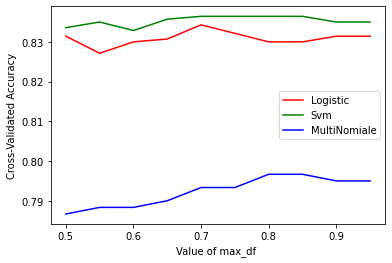

In [70]:
log = scores['logistic']
svc = scores['svm']
mnb = scores['mnb']
best_scores_ngram = best_scores
estimators_ngram = estimators

plt.plot(np.arange(0.5,1,0.05), log, 'r-' ,np.arange(0.5,1,0.05), svc, 'g-',np.arange(0.5,1,0.05), mnb, 'b-')
plt.xlabel('Value of max_df ')
plt.ylabel('Cross-Validated Accuracy')
plt.gca().legend(('Logistic','Svm', 'MultiNomiale'))

TypeError: unsupported operand type(s) for +: 'int' and 'module'

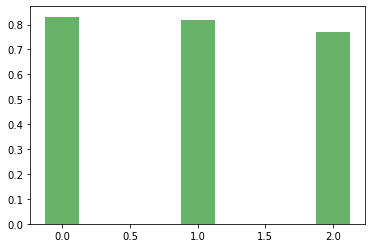

In [31]:

# create plot
fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.25
opacity = 0.6

rects1 = plt.bar(index , log, bar_width, alpha = opacity, color = 'g', label = 'Logistic')

rects2 = plt.bar(index, svm, bar_width, alpha = opacity, color='r', label='svm')

rects3 = plt.bar(index , mnb, bar_width, alpha = opacity, color='b', label='MultiNB')


plt.xlabel('Ngrams')
plt.ylabel('Scores')
plt.title('Scores by model')
plt.xticks(index + bar_width, ( '(1,1)-gram', '(1,2)-gram', '(2,2)-gram'))
plt.legend()

plt.tight_layout()
plt.show()

### Taille vocab

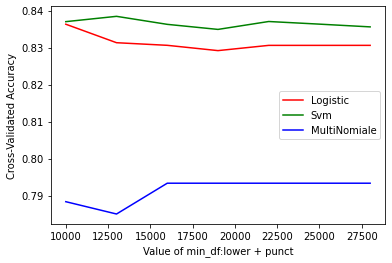

In [24]:
log = scores['logistic']
svc = scores['svm']
mnb = scores['mnb']
best_scores_len

plt.plot(np.arange(10000, 30000, 3000 ), log, 'r-' , np.arange(10000, 30000, 3000 ), svc, 'g-', np.arange(10000, 30000, 3000 ), mnb, 'b-')
plt.xlabel('Value of vocabulary length:lower + punct')
plt.ylabel('Cross-Validated Accuracy')
plt.gca().legend(('Logistic','Svm', 'MultiNomiale'))

## min_df

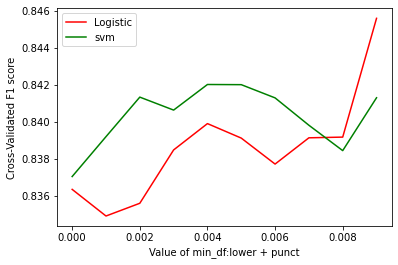

In [215]:
log = scores['logistic']
plt.plot(np.arange(0, 0.01, 0.001 ), log, 'r-' , np.arange(0, 0.01, 0.001 ), svc, 'g-')
plt.xlabel('Value of min_df:lower + punct')
plt.ylabel('Cross-Validated F1 score')
plt.gca().legend(('Logistic','svm'))

### campagne d'éxperience


#### v0 : [token_regex, stop_word, stem]


In [37]:
tran1 = tranform(alltxts)

In [38]:
corpus = tran1.text_trans()
X = tran1.vect(corpus)

In [39]:
nm = NearMiss()
X_eq2, y_eq2 = nm.fit_resample(X, alllabs)

In [40]:
X_tr, X_test, y_tr, y_test = train_test_split(X_eq2, y_eq2,test_size = 0.3, random_state = 0)

#### v1 :  [token_regex]


In [58]:
tran2 = tranform(alltxts)

In [59]:
corpus1 = tran2.text_trans(2)
X1 = tran2.vect_tfidf(corpus1)

In [60]:
X_tr, X_test, y_tr, y_test = train_test_split(X1.toarray(),alllabs,test_size = 0.3, random_state = 0)

#### v2  [ token_regex,  stop_word ]

In [ ]:
tran3 = tranform(alltxts)

In [ ]:
corpus2 = tran3.text_trans(3)
X2 = tran3.vect_tfidf(corpus2)

In [ ]:
X_tr, X_test, y_tr, y_test = train_test_split(X2.toarray(),alllabs,test_size = 0.3, random_state = 0)

#### v3 :  [ token_regex, stem]

In [ ]:
tran4 = tranform(alltxts)

In [ ]:
corpus3 = tran4.text_trans(4)
X3 = tran4.vect_tfidf(corpus3)

In [ ]:
X_tr, X_test, y_tr, y_test = train_test_split(X3.toarray(),alllabs,test_size = 0.3, random_state = 0)

## GridSearch

In [12]:
models={
        "logistic": lin.LogisticRegression(max_iter = 10000),
        "svm" : svm.SVC(max_iter = 10000),
        "mnb" : MultinomialNB()
        }

In [24]:
grid_mean_scores = dict()
estimators = []
for mod in models.keys():
    
    if mod == 'svm':
            
        param_grid = {
            "C" : [0.1, 0.5, 0.9,1,2],
            "kernel": ['linear']
        }
            
    elif mod == 'logistic':
        
        param_grid = {
            "C" : [0.05,0.1,0.5,0.8,1]
        }
    
    if mod != "mnb":
        grid = GridSearchCV(models[mod], param_grid, cv=5, scoring='f1')
        grid.fit(X_tr, y_tr)
        print(pd.DataFrame(grid.cv_results_)[['mean_test_score', 'params']])
        grid_mean_scores[mod] = grid.cv_results_['mean_test_score']
        estimators.append(grid)
    else : 
        models[mod].fit(X_tr,y_tr)
        grid_mean_scores[mod] = models[mod].score(X_test,y_test)
        print(models[mod].score(X_test,y_test))
                                   

   mean_test_score       params
0         0.786347  {'C': 0.05}
1         0.804126   {'C': 0.1}
2         0.815555   {'C': 0.5}
3         0.821010   {'C': 0.8}
4         0.822839     {'C': 1}
   mean_test_score                          params
0         0.671725  {'C': 0.1, 'kernel': 'linear'}
1         0.822725  {'C': 0.5, 'kernel': 'linear'}
2         0.844717  {'C': 0.9, 'kernel': 'linear'}
3         0.841627    {'C': 1, 'kernel': 'linear'}
4         0.843152    {'C': 2, 'kernel': 'linear'}
0.77


## V2

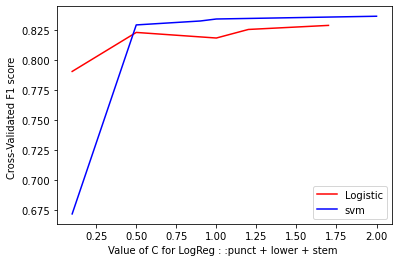

In [20]:
plt.plot([0.1,0.5,1,1.2,1.7], log, 'r-', [0.1, 0.5, 0.9,1,2], svm , 'b-' )
plt.xlabel('Value of C for LogReg : :punct + lower + stem ')
plt.ylabel('Cross-Validated F1 score ')
plt.gca().legend(('Logistic','svm'))

### V0 tfidf

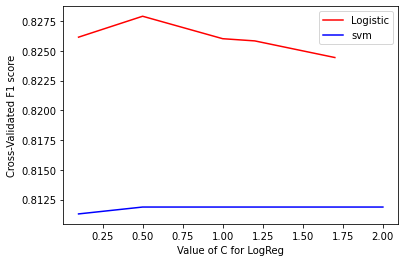

In [55]:
plt.plot([0.1,0.5,1,1.2,1.7], log, 'r-', [0.1, 0.5, 0.9,1,2], svm , 'b-' )
plt.xlabel('Value of C for LogReg')
plt.ylabel('Cross-Validated F1 score')
plt.gca().legend(('Logistic','svm'))

### v3 vect_tf_idf

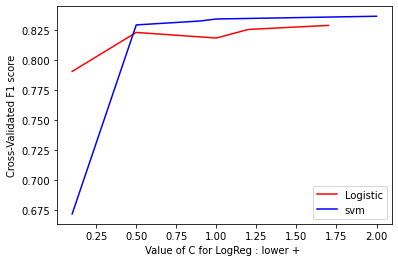

In [28]:
plt.plot([0.1,0.5,1,1.2,1.7], log, 'r-', [0.1, 0.5, 0.9,1,2], svm , 'b-' )
plt.xlabel('Value of C for LogReg : lower + ')
plt.ylabel('Cross-Validated F1 score')
plt.gca().legend(('Logistic','svm'))

### v2 : tf_idf vect 

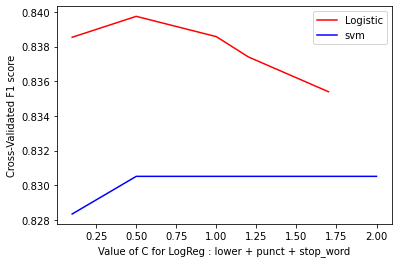

In [25]:
plt.plot([0.1,0.5,1,1.2,1.7], log, 'r-', [0.1, 0.5, 0.9,1,2], svm , 'b-' )
plt.xlabel('Value of C for LogReg : lower + punct + stop_word')
plt.ylabel('Cross-Validated F1 score')
plt.gca().legend(('Logistic','svm'))

## vect

In [145]:
log = grid_mean_scores3['logistic']

Text(0, 0.5, 'Cross-Validated F1 score')

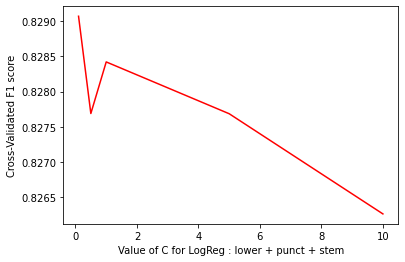

In [161]:
plt.plot([0.1,0.5,1,5,10], log, 'r-' )
plt.xlabel('Value of C for LogReg : lower + punct + stem')
plt.ylabel('Cross-Validated F1 score')


In [142]:
log = grid_mean_scores0['logistic']

Text(0, 0.5, 'Cross-Validated F1 score')

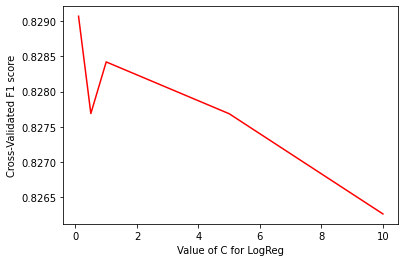

In [162]:
plt.plot([0.1,0.5,1,5,10], log, 'r-' )
plt.xlabel('Value of C for LogReg')
plt.ylabel('Cross-Validated F1 score')

In [ ]:
log = grid_mean_scores2['logistic']

Text(0, 0.5, 'Cross-Validated F1 score')

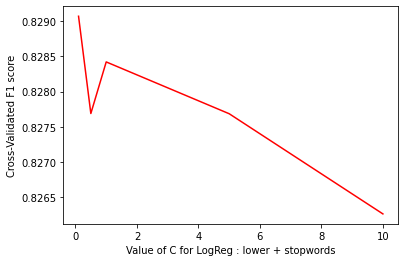

In [163]:
plt.plot([0.1,0.5,1,5,10], log, 'r-' )
plt.xlabel('Value of C for LogReg : lower + stopwords')
plt.ylabel('Cross-Validated F1 score')

# Predictions

In [61]:
#best_modele = lin.LogisticRegression(C = 0.5)
best_modele = svm.LinearSVC(C=0.9,max_iter = 10000) 
#best_modele = svm.SVC(C=10, kernel = 'rbf' )
#best_modele = svm.SVC(C=10, kernel = 'rbf' )

#best_modele = svm.LinearSVC(C=0.9)
#best_modele = lin.LogisticRegression(max_iter = 10000, C=0.5)
best_modele.fit(X_tr,y_tr)

LinearSVC(C=0.9, max_iter=10000)

In [35]:
def write_predictions(X, model, fname):
    """predicts the vectorized data using model, writes the predictions on each line of file and returns prediction"""
    pred  = model.predict(X)
    f = open(fname, "w")
    f.write('\n'.join(map(str, pred)))
    f.close()
    return pred

In [36]:
def load_test(fname):
    with open(fname, "r") as tf:
        alltxts = tf.read().split('\n')
        
    return alltxts[:-1]

In [60]:
with open( "movies.txt", "r") as tf:
    alltxts_test = tf.read().split('\n')

In [47]:
fname2 = "./test/sentiment/testSentiment.txt"
alltxts_test = load_test(fname2)

In [48]:
tran_test = tranform(alltxts_test)
corpus_test = tran_test.text_trans(3)

vectorizer2 = CountVectorizer(vocabulary = tran3.vocabulary)
X_test = vectorizer2.transform(corpus_test)

In [40]:
y_pred = write_predictions(X_test,best_modele,"./res1.txt")

In [56]:
pred  = best_modele.predict(X_test)
f = open('./res1.txt', "w")
f.write('\n'.join(map(str, pred)))
f.close()

### World Cloud

In [38]:
tokenizer = nltk.RegexpTokenizer(r"[a-zA-Z]{3,}")

In [39]:
text = [tokenizer.tokenize(doc) for doc in alltxts]

In [49]:
stop_words = stopwords.words("english")

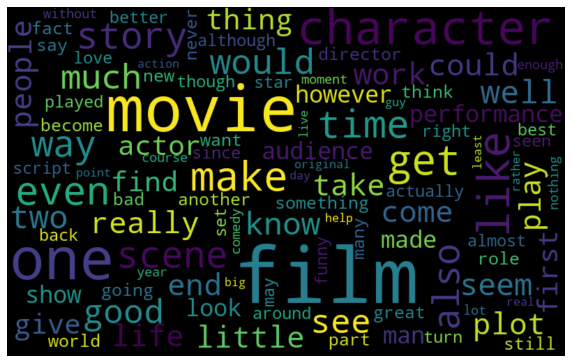

In [52]:
negative_words = ' '.join(' '.join(text[i]) for i in range(len(text))) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,stopwords =stop_words,max_words = 100).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

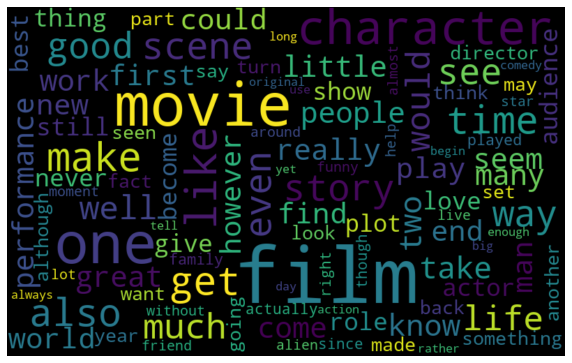

In [51]:
positive_words = ' '.join(' '.join(text[i]) for i in range(len(text)) if (alllabs[i]==0)) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,stopwords =stop_words,max_words = 100).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

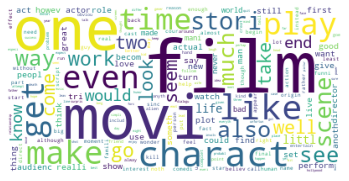

In [61]:
text = " ".join(word for word in text)

wordcloud = WordCloud(background_color = 'white', stopwords = stop_words,max_words = 200).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Quels sont les 100 mots dont la fréquence documentaire est la plus grande ?

In [91]:
from collections import Counter 

Counter = Counter(text)
most_occur = Counter.most_common(10000)

less_occur = list(set(text) - set(most_occur))


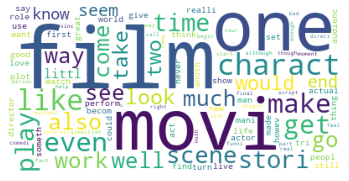

In [70]:
text = " ".join(word for word in less_occur)

wordcloud = WordCloud(background_color = 'white', stopwords = stop_words,max_words = 100).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()